# Assignment 1
**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, RNNs, Transformers, Huggingface



# Contact
For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

- Federico Ruggeri -> federico.ruggeri6@unibo.it
- Eleonora Mancini -> e.mancini@unibo.it

Professor:
- Paolo Torroni -> p.torroni@unibo.it

# Introduction
You are asked to address the [EXIST 2023 Task 2](https://clef2023.clef-initiative.eu/index.php?page=Pages/labs.html#EXIST) on sexism detection.

## Problem Definition

This task aims to categorize the sexist messages according to the intention of the author in one of the following categories: (i) direct sexist message, (ii) reported sexist message and (iii) judgemental message.

### Examples:

#### DIRECT 
The intention was to write a message that is sexist by itself or incites to be sexist, as in:

''*A woman needs love, to fill the fridge, if a man can give this to her in return for her services (housework, cooking, etc), I don’t see what else she needs.*''

#### REPORTED
The intention is to report and share a sexist situation suffered by a woman or women in first or third person, as in:

''*Today, one of my year 1 class pupils could not believe he’d lost a race against a girl.*''

#### JUDGEMENTAL
The intention was to judge, since the tweet describes sexist situations or behaviours with the aim of condemning them.

''*As usual, the woman was the one quitting her job for the family’s welfare…*''

# [Task 1 - 1.0 points] Corpus

We have preparared a small version of EXIST dataset in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material/tree/main/2025-2026/Assignment%201/data).

Check the `A1/data` folder. It contains 3 `.json` files representing `training`, `validation` and `test` sets.


### Dataset Description
- The dataset contains tweets in both English and Spanish.
- There are label for multiple tasks, but we are focusing on **Task 2**.
- For Task 2, label are assigned by six annotators.
- The label for Task 2 represent whether the tweet is non-sexist ('-') or its sexist intention ('DIRECT', 'REPORTED', 'JUDGEMENTAL').







### Example

```
    "203260": {
        "id_EXIST": "203260",
        "lang": "en",
        "tweet": "ik when mandy says “you look like a whore” i look cute as FUCK",
        "number_annotators": 6,
        "annotators": ["Annotator_473", "Annotator_474", "Annotator_475", "Annotator_476", "Annotator_477", "Annotator_27"],
        "gender_annotators": ["F", "F", "M", "M", "M", "F"],
        "age_annotators": ["18-22", "23-45", "18-22", "23-45", "46+", "46+"],
        "label_task1": ["YES", "YES", "YES", "NO", "YES", "YES"],
        "labels_task2": ["DIRECT", "DIRECT", "REPORTED", "-", "JUDGEMENTAL", "REPORTED"],
        "labels_task3": [
          ["STEREOTYPING-DOMINANCE"],
          ["OBJECTIFICATION"],
          ["SEXUAL-VIOLENCE"],
          ["-"],
          ["STEREOTYPING-DOMINANCE", "OBJECTIFICATION"],
          ["OBJECTIFICATION"]
        ],
        "split": "TRAIN_EN"
      }
    }
```

### Instructions
1. **Download** the `A1/data` folder.
2. **Load** the three JSON files and encode them as ``pandas.DataFrame``.
3. **Aggregate labels** for Task 2 using majority voting and store them in a new dataframe column called `label`. Items without a clear majority will be removed from the dataset.
4. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.
5. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `label`.
6. **Encode the `label` column**: Use the following mapping

```
{
    '-': 0,
    'DIRECT': 1,
    'JUDGEMENTAL': 2,
    'REPORTED': 3
}
```

In [3]:
from collections import Counter
import json
from pathlib import Path
import pandas as pd
import re
import unicodedata
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize

In [4]:
path_train = "data/training.json"
df_train = pd.read_json(path_train)
df_train = df_train.reset_index(drop=False).rename(columns={"index": "key"}).transpose()
df_train.columns = df_train.iloc[0]
df_train = df_train[1:]
df_train.head()
print(f"Loaded {len(df_train)} records from {path_train}")
# df_train.head()

path_test = "data/test.json"
df_test = pd.read_json(path_test)
df_test = df_test.reset_index(drop=False).rename(columns={"index": "key"}).transpose()
df_test.columns = df_test.iloc[0]
df_test = df_test[1:]
df_test.head()
print(f"Loaded {len(df_test)} records from {path_test}")
# df_test.head()

path_val = "data/validation.json"
df_val = pd.read_json(path_val)
df_val = df_val.reset_index(drop=False).rename(columns={"index": "key"}).transpose()
df_val.columns = df_val.iloc[0]
df_val = df_val[1:]
df_val.head()
print(f"Loaded {len(df_val)} records from {path_val}")
# df_val.head()

Loaded 6920 records from data/training.json
Loaded 312 records from data/test.json
Loaded 726 records from data/validation.json


In [5]:
df_val.head()

key,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
300001,300001,es,@Fichinescu La comunidad gamer es un antro de ...,6,"[Annotator_726, Annotator_727, Annotator_357, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, YES, NO, YES, NO]","[-, JUDGEMENTAL, JUDGEMENTAL, -, REPORTED, -]","[[-], [MISOGYNY-NON-SEXUAL-VIOLENCE], [MISOGYN...",DEV_ES
300002,300002,es,@anacaotica88 @MordorLivin No me acuerdo de lo...,6,"[Annotator_731, Annotator_732, Annotator_315, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[YES, YES, NO, YES, YES, YES]","[JUDGEMENTAL, REPORTED, -, JUDGEMENTAL, JUDGEM...","[[IDEOLOGICAL-INEQUALITY, STEREOTYPING-DOMINAN...",DEV_ES
300003,300003,es,@cosmicJunkBot lo digo cada pocos dias y lo re...,6,"[Annotator_735, Annotator_736, Annotator_345, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",DEV_ES
300004,300004,es,Also mientras les decia eso la señalaba y deci...,6,"[Annotator_259, Annotator_739, Annotator_291, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, YES, YES, YES, YES]","[-, REPORTED, REPORTED, REPORTED, JUDGEMENTAL,...","[[-], [SEXUAL-VIOLENCE], [SEXUAL-VIOLENCE], [S...",DEV_ES
300005,300005,es,"And all people killed, attacked, harassed by ...",6,"[Annotator_731, Annotator_732, Annotator_315, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, NO, NO, NO, NO]","[-, DIRECT, -, -, -, -]","[[-], [STEREOTYPING-DOMINANCE], [-], [-], [-],...",DEV_ES


In [6]:
df_test.head()

key,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
400178,400178,en,1st day at the pool on a beautiful Sunday in N...,6,"[Annotator_764, Annotator_765, Annotator_766, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",DEV_EN
400179,400179,en,“I like your outfit too except when i dress up...,6,"[Annotator_805, Annotator_426, Annotator_806, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[YES, YES, YES, YES, YES, NO]","[JUDGEMENTAL, DIRECT, REPORTED, DIRECT, REPORT...","[[OBJECTIFICATION], [OBJECTIFICATION, MISOGYNY...",DEV_EN
400180,400180,en,"@KNasFanFic 🥺💖 same, though!!! the angst just ...",6,"[Annotator_795, Annotator_796, Annotator_797, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",DEV_EN
400181,400181,en,@themaxburns @GOP Fuck that cunt. Tried to vot...,6,"[Annotator_795, Annotator_796, Annotator_797, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, YES, YES, YES, YES]","[-, DIRECT, JUDGEMENTAL, DIRECT, DIRECT, DIRECT]","[[-], [IDEOLOGICAL-INEQUALITY, MISOGYNY-NON-SE...",DEV_EN
400182,400182,en,@ultshunnie u gotta say some shit like “i’ll f...,6,"[Annotator_770, Annotator_771, Annotator_772, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[YES, YES, YES, YES, YES, YES]","[DIRECT, REPORTED, DIRECT, DIRECT, JUDGEMENTAL...","[[OBJECTIFICATION, SEXUAL-VIOLENCE], [SEXUAL-V...",DEV_EN


In [ ]:
# Adding the new column 'label'
def most_common_label(labels):

    if ((len(Counter(labels))>1) and (Counter(labels).most_common(1)[0][1] == Counter(labels).most_common(2)[1][1])):
        return pd.NA
    # print(Counter(labels).most_common(2))
    return Counter(labels).most_common(1)[0][0]

def secondary_most_common_label(labels):

    if ((len(Counter(labels))>1) and (Counter(labels).most_common(1)[0][1] == Counter(labels).most_common(2)[1][1])):
        return pd.NA
    elif (len(Counter(labels))<2): 
        return pd.NA
    return Counter(labels).most_common(2)[1][0]

# Populating the new column with the most common label for each row
df_train['label'] = df_train['labels_task2'].apply(most_common_label)
df_test['label'] = df_test['labels_task2'].apply(most_common_label)
df_test['secondary'] = df_test['labels_task2'].apply(secondary_most_common_label)
df_val['label'] = df_val['labels_task2'].apply(most_common_label)

# Deleting all the rows with no most common label
df_train_dropna = df_train.dropna(subset=['label'])    
df_test_dropna = df_test.dropna(subset=['label'])    
df_val_dropna = df_val.dropna(subset=['label'])

# Filtering only English tweets and selecting relevant columns
df_train_en = df_train_dropna[df_train_dropna['lang'] == 'en'][['id_EXIST','lang','tweet','label']]
df_test_en = df_test_dropna[df_test_dropna['lang']=='en'][['id_EXIST','lang','tweet','label', 'secondary']]
df_val_en = df_val_dropna[df_val_dropna['lang']=='en'][['id_EXIST','lang','tweet','label']]



[('REPORTED', 3), ('JUDGEMENTAL', 2)]
[('-', 5), ('DIRECT', 1)]
[('-', 6)]
[('-', 3), ('REPORTED', 2)]
[('-', 6)]
[('-', 3), ('DIRECT', 2)]
[('DIRECT', 5), ('JUDGEMENTAL', 1)]
[('-', 6)]
[('-', 5), ('DIRECT', 1)]
[('-', 6)]
[('-', 6)]
[('-', 6)]
[('-', 5), ('DIRECT', 1)]
[('-', 5), ('REPORTED', 1)]
[('-', 4), ('REPORTED', 1)]
[('-', 5), ('DIRECT', 1)]
[('-', 5), ('DIRECT', 1)]
[('-', 6)]
[('-', 6)]
[('-', 4), ('DIRECT', 2)]
[('-', 6)]
[('-', 4), ('REPORTED', 1)]
[('-', 6)]
[('-', 3), ('REPORTED', 2)]
[('-', 5), ('DIRECT', 1)]
[('DIRECT', 3), ('-', 2)]
[('-', 6)]
[('-', 4), ('JUDGEMENTAL', 1)]
[('-', 5), ('DIRECT', 1)]
[('-', 4), ('JUDGEMENTAL', 2)]
[('-', 5), ('JUDGEMENTAL', 1)]
[('-', 5), ('JUDGEMENTAL', 1)]
[('DIRECT', 5), ('-', 1)]
[('-', 6)]
[('-', 3), ('REPORTED', 2)]
[('-', 4), ('JUDGEMENTAL', 2)]
[('-', 5), ('REPORTED', 1)]
[('-', 3), ('REPORTED', 2)]
[('REPORTED', 3), ('JUDGEMENTAL', 2)]
[('-', 3), ('JUDGEMENTAL', 2)]
[('-', 6)]
[('REPORTED', 4), ('-', 2)]
[('-', 6)]
[('-', 5),

In [86]:
df_test_en.head()

key,id_EXIST,lang,tweet,label,secondary
400178,400178,en,1st day at the pool on a beautiful Sunday in N...,-,<NA>
400180,400180,en,"@KNasFanFic 🥺💖 same, though!!! the angst just ...",-,<NA>
400181,400181,en,@themaxburns @GOP Fuck that cunt. Tried to vot...,DIRECT,-
400182,400182,en,@ultshunnie u gotta say some shit like “i’ll f...,DIRECT,REPORTED
400183,400183,en,"@FernsLewds “Mmm, fuck that cunt is hungry for...",DIRECT,-


In [89]:
# Mapping labels to integers
mapping = {
    '-': 0,
    'DIRECT': 1,
    'JUDGEMENTAL': 2,
    'REPORTED': 3
}

df_train_en['label'] = df_train_en['label'].map(mapping)
df_test_en['label'] = df_test_en['label'].map(mapping)
df_val_en['label'] = df_val_en['label'].map(mapping)


In [90]:
train_df = df_train_en
val_df = df_val_en
test_df = df_test_en

In [92]:
# Save the processed dataframes for future tasks
train_df.to_csv('processed_train.csv', index=False)
val_df.to_csv('processed_validation.csv', index=False)
test_df.to_csv('processed_test.csv', index=False)


# [Task2 - 0.5 points] Data Cleaning
In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis.



### Instructions
- **Remove emojis** from the tweets.
- **Remove hashtags** (e.g., `#example`).
- **Remove mentions** such as `@user`.
- **Remove URLs** from the tweets.
- **Remove special characters and symbols**.
- **Remove specific quote characters** (e.g., curly quotes).
- **Perform lemmatization** to reduce words to their base form.

In [12]:
from collections import Counter
import json
from pathlib import Path
import pandas as pd
import re
import unicodedata
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize

from spellchecker import SpellChecker

### Defining dataframes

In [93]:
# Task 2 - Data Cleaning
# Download required NLTK data
print("Downloading NLTK resources...")
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

train_df = pd.read_csv('processed_train.csv')
val_df = pd.read_csv('processed_validation.csv')
test_df = pd.read_csv('processed_test.csv')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dales\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dales\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\dales\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Cleaning

In [14]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
spell = SpellChecker()

# CLEANING FUNCTION
def clean_tweet(tweet, spell_check=False):
    """
    Clean and preprocess a tweet by removing unwanted elements and performing lemmatization
    """
    if pd.isna(tweet):
        return ""
    
    # Convert to string if not already
    tweet = str(tweet)

    # Remove emojis and emoticons
    # First pattern: remove common emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"  # Misc symbols
                           u"\U000024C2-\U0001F251"  # Enclosed characters 
                           "]+", flags=re.UNICODE)
    tweet = emoji_pattern.sub('', tweet)
    
    # Remove hashtags
    tweet = re.sub(r'#\w+', '', tweet)   

    # Remove mentions
    tweet = re.sub(r'@\w+', '', tweet)
    
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet)

    # Remove special characters and symbols. Keep letters, numbers, and basic punctuation (.!?)
    tweet = re.sub(r'([.!?])', r' \1 ', tweet)
    tweet = re.sub(r'[^\w\s.!?]', ' ', tweet)

    tweet = re.sub(r"(.)\1{2,}", r"\1\1", tweet)

    # Remove specific quote characters
    tweet = re.sub(r'[“”‘’"\']', '', tweet)
    
    # Tokenize and lemmatize
    tokens = word_tokenize(tweet)
    lemmatized_tokens = []
    
    for token in tokens:
        if token.isalpha():
            if spell_check:
                spell.correction(token)
            token = token.lower() or token
            # Lemmatize (try noun first,verb, then adjectives)
            lemma = lemmatizer.lemmatize(token, pos='n')  # noun
            lemma = lemmatizer.lemmatize(lemma, pos='v')           # verb
            lemma = lemmatizer.lemmatize(lemma, pos='a')          # adjective
            lemmatized_tokens.append(lemma)
        else:
            lemmatized_tokens.append(token)
    
    # Rejoin tokens
    cleaned_tweet = ' '.join(lemmatized_tokens)
    
    # Remove extra whitespace
    cleaned_tweet = re.sub(r'\s+', ' ', cleaned_tweet).strip() 
    
    return cleaned_tweet

In [94]:
# Apply cleaning 
train_df['tweet'] = train_df['tweet'].apply(clean_tweet)
val_df['tweet'] = val_df['tweet'].apply(clean_tweet)
test_df['tweet'] = test_df['tweet'].apply(clean_tweet)

### Sample visualization

In [16]:
sample_indices = [0, 5, 10]  # Sample indices to display

for idx in sample_indices:
    if idx < len(train_df):
        
        print(f"Example {idx + 1}:")
        print( train_df.iloc[idx]['tweet'])
        print("-" * 80)

Example 1:
ffs ! how about lay the blame on the bastard who murder her ? novel idea i know .
--------------------------------------------------------------------------------
Example 6:
accord to a customer i have plenty of time to go spend the stirling coin he want to pay me with in derry . just like any other woman i m sure of it . in retail .
--------------------------------------------------------------------------------
Example 11:
mean woman usually end up in low pay support work when that start to change traditionalist notice unfairness that previously hasn t bother them at all .
--------------------------------------------------------------------------------


Saving csv's to avoid rerunning cleaning

In [95]:
train_df.to_csv('cleaned_train.csv', index=False)
val_df.to_csv('cleaned_validation.csv', index=False)
test_df.to_csv('cleaned_test.csv', index=False)

# [Task 3 - 0.5 points] Text Encoding
To train a neural sexism classifier, you first need to encode text into numerical format.




In [18]:
from collections import Counter
import json
from pathlib import Path
import pandas as pd
import re
import unicodedata
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from spellchecker import SpellChecker
import gensim

### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.





### What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., ``<UNK>``) and a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)



### More about OOV

For a given token:

* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).
* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.

Your vocabulary **should**:

* Contain all tokens in train set; or
* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!

Reading the cleaned .csv files

In [96]:
# Task 3 - Text Encoding with GloVe Embeddings
import numpy as np
from collections import defaultdict
from collections import OrderedDict
import requests
import os
import zipfile
from tqdm import tqdm
import gensim
import gensim.downloader as gloader
from typing import List, Callable, Dict

# Load cleaned datasets
train_df = pd.read_csv('cleaned_train.csv')
val_df = pd.read_csv('cleaned_validation.csv')
test_df = pd.read_csv('cleaned_test.csv')

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Training samples: 2873
Validation samples: 150
Test samples: 280


Defining a function to load an embedding model

In [20]:
def load_embedding_model(model_type: str,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = ""
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")
        
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        print('FastText: 300')
        raise e

    return emb_model

In [21]:
# Modify these variables as you wish!
# Glove -> 50, 100, 200, 300
# Word2Vec -> 300
# Fasttext -> 300

embedding_dimension = 100

embedding_model = load_embedding_model(model_type="glove",
                                       embedding_dimension=embedding_dimension )

Defining a function for building the vocabulary

In [22]:
def build_vocabulary(df: pd.DataFrame) -> (Dict[int, str], Dict[str, int], List[str]):
    """
    Given a dataset, builds the corresponding word vocabulary.

    :param df: dataset from which we want to build 
    the word vocabulary (pandas.DataFrame)
    :return:
      - word vocabulary: vocabulary index to word
      - inverse word vocabulary: word to vocabulary index
      - word listing: set of unique terms that build up the vocabulary
    """
    idx_to_word = OrderedDict()
    word_to_idx = OrderedDict()

    # reserve special tokens
    word_to_idx['<PAD>'] = 0
    idx_to_word[0] = '<PAD>'
    word_to_idx['<UNK>'] = 1
    idx_to_word[1] = '<UNK>'

    
    curr_idx = 2  # start from 2 to reserve 0 for <PAD> and 1 fro <UNK>
    for sentence in tqdm(df.tweet.values):
        tokens = sentence.split()
        for token in tokens:
            if token not in word_to_idx:
                word_to_idx[token] = curr_idx
                idx_to_word[curr_idx] = token
                curr_idx += 1

    word_listing = list(idx_to_word.values())
    return idx_to_word, word_to_idx, word_listing

Building our vocabulary, checking its size and printing some words 

In [23]:
idx_to_word, word_to_idx, word_listing = build_vocabulary(train_df)

print(f'[Debug] Index -> Word vocabulary size: {len(idx_to_word)}')
print(f'[Debug] Word -> Index vocabulary size: {len(word_to_idx)}')

some_words = [(idx_to_word[idx], idx) for idx in np.arange(10) ]
print(f'[Debug] Some words: {some_words}')

vocab_size = len(word_to_idx)

100%|██████████| 2873/2873 [00:00<00:00, 93831.65it/s]

[Debug] Index -> Word vocabulary size: 8671
[Debug] Word -> Index vocabulary size: 8671
[Debug] Some words: [('<PAD>', np.int64(0)), ('<UNK>', np.int64(1)), ('ffs', np.int64(2)), ('!', np.int64(3)), ('how', np.int64(4)), ('about', np.int64(5)), ('lay', np.int64(6)), ('the', np.int64(7)), ('blame', np.int64(8)), ('on', np.int64(9))]


In [68]:
print("gangbanged" in word_listing)

True


### Inspecting OOVs

Checking which terms are OOV and checking the percentage of OOV terms in our vocabulary

In [24]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

In [25]:
oov_terms = check_OOV_terms(embedding_model, word_listing)
oov_percentage = float(len(oov_terms)) * 100 / len(word_listing)
print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")

oov_sample = oov_terms[:30]
print(f"Some OOV terms: {oov_sample}")

Total OOV terms: 960 (11.07%)
Some OOV terms: ['myt', 'I2', 'clit', 'ambie', 'iche', 'papism', 'maaster', 'nalang', 'idrk', 'thems', 'ᴗ', 'foilage', 'voice10', 'cashmeets', 'Web3', 'pathologises', 'bitvh', 'unke', 'plandemic', 'applebees', 'archipiélago', 'asapits', 'egirl', 'likeʸᵒᵘ', 'omw', 'nsfw', 'deltarune', 'AllVoteBlueIn2022', 'antifa', 'dababy']


### Building embedding matrix

In [26]:
''' previous version of the function
def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int],
                           vocab_size: int,
                           oov_terms: List[str]) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given 
    a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    :param oov_terms: list of OOV terms (list)

    :return
        - embedding matrix that assigns a high dimensional vector 
        to each word in the dataset specific vocabulary (shape |V| x d)
    """
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    for word, idx in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix
'''

' previous version of the function\ndef build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,\n                           embedding_dimension: int,\n                           word_to_idx: Dict[str, int],\n                           vocab_size: int,\n                           oov_terms: List[str]) -> np.ndarray:\n    """\n    Builds the embedding matrix of a specific dataset given \n    a pre-trained word embedding model\n\n    :param embedding_model: pre-trained word embedding model\n    :param word_to_idx: vocabulary map (word -> index) (dict)\n    :param vocab_size: size of the vocabulary\n    :param oov_terms: list of OOV terms (list)\n\n    :return\n        - embedding matrix that assigns a high dimensional vector \n        to each word in the dataset specific vocabulary (shape |V| x d)\n    """\n    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)\n    for word, idx in tqdm(word_to_idx.items()):\n        try:\n          

In [27]:
def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int],
                           vocab_size: int,
                           oov_terms: List[str]) -> np.ndarray:
    """
    Builds the embedding matrix keeping PAD (idx 0) as all-zeros so mask_zero works.
    """
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    rng = np.random.RandomState(seed=12345)

    # Fill embeddings but do NOT overwrite PAD (idx==0)
    for word, idx in tqdm(word_to_idx.items()):
        if idx == 0:
            # keep PAD as zero vector for mask_zero=True
            continue
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = rng.uniform(low=-0.05, high=0.05, size=embedding_dimension).astype(np.float32)

        embedding_matrix[idx] = embedding_vector

    # Set a stable <UNK> vector (mean of known embeddings) if available
    unk_idx = word_to_idx.get('<UNK>', None)
    if unk_idx is not None and unk_idx != 0:
        # average only non-zero rows (skip PAD)
        non_zero_mask = np.linalg.norm(embedding_matrix, axis=1) > 0
        if non_zero_mask.sum() > 0:
            embedding_matrix[unk_idx] = embedding_matrix[non_zero_mask].mean(axis=0).astype(np.float32)
        else:
            # fallback
            embedding_matrix[unk_idx] = rng.uniform(low=-0.05, high=0.05, size=embedding_dimension).astype(np.float32)

    return embedding_matrix

In [28]:
# Testing
embedding_dimension = 100
# embedding_dimension is defined also previously when uploading GloVe, these two parameters must match
embedding_matrix = build_embedding_matrix(embedding_model,
                                          embedding_dimension,
                                          word_to_idx,
                                          vocab_size,
                                          oov_terms)
print(f"Embedding matrix shape: {embedding_matrix.shape}")

100%|██████████| 8671/8671 [00:00<00:00, 167760.55it/s]

Embedding matrix shape: (8671, 100)


# [Task 4 - 1.0 points] Model definition

You are now tasked to define your sexism classifier.




### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.

* **Stacked**: add an additional Bidirectional LSTM layer to the Baseline model.

**Note**: You are **free** to experiment with hyper-parameters.

### Token to embedding mapping

You can follow two approaches for encoding tokens in your classifier.

### Work directly with embeddings

- Compute the embedding of each input token
- Feed the mini-batches of shape ``(batch_size, # tokens, embedding_dim)`` to your model

### Work with Embedding layer

- Encode input tokens to token ids
- Define a Embedding layer as the first layer of your model
- Compute the embedding matrix of all known tokens (i.e., tokens in your vocabulary)
- Initialize the Embedding layer with the computed embedding matrix
- You are **free** to set the Embedding layer trainable or not

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

### Embedding model definition

In [97]:
train_maxlen = max([len(train_df['tweet'][i].split()) for i in range(len(train_df))])
val_maxlen = max([len(val_df['tweet'][i].split()) for i in range(len(val_df))])
test_maxlen = max([len(test_df['tweet'][i].split()) for i in range(len(test_df))])

max_len = max(train_maxlen, val_maxlen, test_maxlen)
print(f"Max tweet length after cleaning: {max_len} tokens")

Max tweet length after cleaning: 71 tokens


In [31]:
# I chose the 'embedding layer' option

embedding = Embedding(input_dim=vocab_size,
                        output_dim=embedding_dimension,
                        weights=[embedding_matrix],
                        mask_zero=True,                   # automatically masks padding tokens
                        trainable = False, # to freeze the embeddings during training
                        name='encoder_embedding')

############################################################################################

############################################################################################

Run from here to avoid dwnloading GLoVe

## Baseline model definition

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

In [33]:
# model definition

baseline_model = Sequential([
    # embedding layer
    embedding,
    # Bidirectional LSTM layer
    Bidirectional(LSTM(64, return_sequences=False)),
    # Fully connected (Dense) layer
    Dense((64), activation='relu'),
    Dropout(0.5),
    # Output layer
    Dense(4, activation='softmax')
])

# Use categorical or sparse categorical loss depending on your label encoding
baseline_model.compile(
    loss='sparse_categorical_crossentropy',  # or 'categorical_crossentropy' if one-hot encoded
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

In [34]:
baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_embedding (Embedding)   │ ?                      │       867,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 867,100 (3.31 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 867,100 (3.31 MB)

## Stacked model definition

In [35]:
# model definition

stacked_model = Sequential([
    # embedding layer
    embedding,

    # 1st Bidirectional LSTM layer
    Bidirectional(LSTM(32, return_sequences=True)),
    # 2nd Bidirectional LSTM layer
    Bidirectional(LSTM(32)),
    # Fully connected (Dense) layer
    Dense(32, activation='relu'),
    Dropout(0.5),
    # Output layer
    Dense(4, activation='softmax')
])

# Use categorical or sparse categorical loss depending on your label encoding
stacked_model.compile(
    loss='sparse_categorical_crossentropy',  # or 'categorical_crossentropy' if one-hot encoded
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline and Stacked models.



### Instructions

* Pick **at least** three seeds for robust estimation.
* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute macro F1-score, precision, and recall metrics on the validation set.
* Report average and standard deviation measures over seeds for each metric.
* Pick the **best** performing model according to the observed validation set performance (use macro F1-score).

In [36]:
train_df.head()

,id_EXIST,lang,tweet,label
0,200001,en,ffs ! how about lay the blame on the bastard w...,0
1,200002,en,write a uni essay in my local pub with a coffe...,3
2,200003,en,it be 2021 not 1921 . i dont appreciate that o...,3
3,200004,en,this be unacceptable . use her title a you do ...,0
4,200005,en,make yourself a hard target basically boil dow...,0


### Preparing train and validation sets

In [98]:

from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def texts_to_padded_sequences(texts, word_to_idx, max_len=None, pad_value=0):
    unk_id = word_to_idx.get('<UNK>', None)
    seqs = []
    for t in texts:
        ids = []
        for tok in str(t).split():
            idx = word_to_idx.get(tok, unk_id)
            if idx is None:
                idx = pad_value
            ids.append(idx)
        seqs.append(ids)
    if max_len is None:
        max_len = max((len(s) for s in seqs), default=0)
    arr = pad_sequences(seqs, maxlen=max_len, padding='post', truncating='post', value=pad_value)
    return np.asarray(arr, dtype=np.int32)


# build arrays
X_train = texts_to_padded_sequences(train_df['tweet'].values, word_to_idx)
X_val   = texts_to_padded_sequences(val_df['tweet'].values,   word_to_idx)
X_test  = texts_to_padded_sequences(test_df['tweet'].values,  word_to_idx)

y_train = train_df['label'].values.astype(np.int32)
y_val   = val_df['label'].values.astype(np.int32)
y_test  = test_df['label'].values.astype(np.int32)

In [38]:
# Sanity checks for padding / unknown tokens
pad_idx = word_to_idx.get('<PAD>')
unk_idx = word_to_idx.get('<UNK>')

assert pad_idx is not None, "<PAD> not found in word_to_idx"
assert unk_idx is not None, "<UNK> not found in word_to_idx"
assert pad_idx == 0, f"<PAD> index is {pad_idx}, expected 0"
assert unk_idx == 1, f"<UNK> index is {unk_idx}, expected 1"

print("Embedding matrix shape:", embedding_matrix.shape)
assert embedding_matrix.shape == (vocab_size, embedding_dimension)

# PAD vector in embedding matrix must be all zeros
pad_vec = embedding_matrix[pad_idx]
print("PAD vector norm (embedding_matrix):", np.linalg.norm(pad_vec))
assert np.allclose(pad_vec, 0.0), "PAD vector in embedding_matrix is not all zeros!"

# Check <UNK> vector is not zero (should be distinct)
print("<UNK> vector norm:", np.linalg.norm(embedding_matrix[unk_idx]))

# If you already created the Keras Embedding layer, ensure its weight row 0 is zero
if 'embedding' in globals() and hasattr(embedding, 'get_weights'):
    w = embedding.get_weights()[0]
    print("Embedding layer weights shape:", w.shape)
    if not np.allclose(w[0], 0.0):
        print("-> PAD row in Embedding layer is non-zero. Overwriting to zeros and setting trainable=False.")
        w[0] = np.zeros(embedding_dimension, dtype=np.float32)
        embedding.set_weights([w])
        embedding.trainable = False
    print("PAD vector norm (embedding layer):", np.linalg.norm(embedding.get_weights()[0][0]))

# Quick dataset checks: padding fraction and id ranges
print("X_train shape:", X_train.shape, "X_val shape:", X_val.shape)
pad_frac_train = (X_train == pad_idx).sum() / X_train.size
pad_frac_val = (X_val == pad_idx).sum() / X_val.size
print(f"Pad fraction - train: {pad_frac_train:.4f}, val: {pad_frac_val:.4f}")

# Ensure no accidental use of 0 for unknown tokens (unknowns should be mapped to <UNK>=1)
unique_train = np.unique(X_train)
unique_val = np.unique(X_val)
print("Train token id min/max:", unique_train.min(), unique_train.max())
print("Val token id min/max:  ", unique_val.min(), unique_val.max())

# Optional: list a few token ids that appear in val but are not in vocabulary indices range
out_of_range_val = unique_val[(unique_val < 0) | (unique_val >= vocab_size)]
if len(out_of_range_val):
    print("Warning: token ids in val out of vocab range:", out_of_range_val)
else:
    print("All token ids in train/val are within [0, vocab_size).")

Embedding matrix shape: (8671, 100)
PAD vector norm (embedding_matrix): 0.0
<UNK> vector norm: 1.2724501
Embedding layer weights shape: (8671, 100)
PAD vector norm (embedding layer): 0.0
X_train shape: (2873, 71) X_val shape: (150, 61)
Pad fraction - train: 0.5933, val: 0.5136
Train token id min/max: 0 8670
Val token id min/max:   0 8583
All token ids in train/val are within [0, vocab_size).


In [39]:
# Training: add callbacks and class weights
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

os.makedirs('checkpoints', exist_ok=True)

# compute balanced class weights
cls = np.unique(y_train)
cw = class_weight.compute_class_weight('balanced', classes=cls, y=y_train)
class_weight_dict = {int(k): float(v) for k, v in zip(cls, cw)}

### Plotting function

In [40]:
#plottig function

import matplotlib.pyplot as plt

def plot_train_val_loss(history, label='Model', save_path=None):
    # accept Keras History object or a plain dict
    hist = history.history if hasattr(history, 'history') else history
    loss = hist.get('loss')
    val_loss = hist.get('val_loss')
    if loss is None:
        raise ValueError("history does not contain 'loss' key")
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(epochs, loss, 'o-', label=f'{label} train')
    if val_loss is not None:
        plt.plot(epochs, val_loss, 's--', label=f'{label} val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{label} loss')
    plt.grid(True)
    plt.legend()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

### Baseline Model Training

In [41]:
import random

random_seed1 = 42
random_seed2 = 1312
random_seed3 = 1234

seeds = [random_seed1, random_seed2, random_seed3]

def set_seed(seed):
    tf.random.set_seed(seed)
    random.seed(seed)
    np.random.seed(seed)


Training baseline model n.0 with random seed: 42
Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.2662 - loss: 1.3991
Epoch 1: val_loss improved from None to 1.37200, saving model to checkpoints/baseline_best0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.2938 - loss: 1.3943 - val_accuracy: 0.2667 - val_loss: 1.3720 - learning_rate: 0.0010
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3479 - loss: 1.3404
Epoch 2: val_loss improved from 1.37200 to 1.26589, saving model to checkpoints/baseline_best0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.3247 - loss: 1.3452 - val_accuracy: 0.4800 - val_loss: 1.2659 - learning_rate: 0.0010
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3581 - loss: 1.3113
Epoch 3: val_loss improved from 1.26589 to 1.17530, saving model to checkpoints/baseline_best0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.3439 - loss: 1.3132 - val_accuracy: 0.5133 - val_loss: 1.1753 - learning_rate: 0.0010
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4369 - loss: 1.2186
Epoch 4: val_loss improved from 1.17530 to 1.11788, saving model to checkpoints/baseline_best0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.4288 - loss: 1.2295 - val_accuracy: 0.6000 - val_loss: 1.1179 - learning_rate: 0.0010
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4906 - loss: 1.1720
Epoch 5: val_loss improved from 1.11788 to 1.08222, saving model to checkpoints/baseline_best0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.4800 - loss: 1.1882 - val_accuracy: 0.5733 - val_loss: 1.0822 - learning_rate: 0.0010
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4898 - loss: 1.1294
Epoch 6: val_loss did not improve from 1.08222
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.5005 - loss: 1.1365 - val_accuracy: 0.5467 - val_loss: 1.0992 - learning_rate: 0.0010
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5622 - loss: 1.0460
Epoch 7: val_loss improved from 1.08222 to 0.96784, saving model to checkpoints/baseline_best0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.5590 - loss: 1.0514 - val_accuracy: 0.6467 - val_loss: 0.9678 - learning_rate: 0.0010
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5809 - loss: 0.9667
Epoch 8: val_loss did not improve from 0.96784
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.5694 - loss: 0.9708 - val_accuracy: 0.6400 - val_loss: 1.0115 - learning_rate: 0.0010
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6110 - loss: 0.8989
Epoch 9: val_loss did not improve from 0.96784
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.6067 - loss: 0.8864 - val_accuracy: 0.5933 - val_loss: 1.0400 - learning_rate: 0.0010
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6337 - loss: 0.8346
Epoch 10: val_loss did not improve from 0.96784
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.6272 - loss: 0.8116 - val_accuracy: 0.5933 - val_loss: 1.0254 - learning_rate: 0.0010


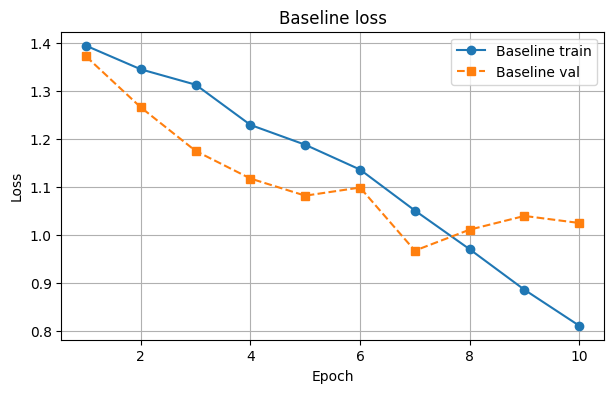


Evaluating baseline model n.0 on test set:
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5393 - loss: 1.0606
_____________________________________________________________________________

Training baseline model n.1 with random seed: 1312
Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2080 - loss: 1.4434
Epoch 1: val_loss improved from None to 1.36311, saving model to checkpoints/baseline_best1.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.2621 - loss: 1.3899 - val_accuracy: 0.3333 - val_loss: 1.3631 - learning_rate: 0.0010
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.2605 - loss: 1.3927
Epoch 2: val_loss did not improve from 1.36311
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.3028 - loss: 1.3436 - val_accuracy: 0.1267 - val_loss: 1.4360 - learning_rate: 0.0010
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3280 - loss: 1.3473
Epoch 3: val_loss improved from 1.36311 to 1.31425, saving model to checkpoints/baseline_best1.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.4083 - loss: 1.2909 - val_accuracy: 0.4000 - val_loss: 1.3143 - learning_rate: 0.0010
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4309 - loss: 1.3045
Epoch 4: val_loss did not improve from 1.31425
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.4668 - loss: 1.2491 - val_accuracy: 0.4067 - val_loss: 1.3452 - learning_rate: 0.0010
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4823 - loss: 1.2437
Epoch 5: val_loss did not improve from 1.31425
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.5190 - loss: 1.1756 - val_accuracy: 0.3333 - val_loss: 1.3949 - learning_rate: 0.0010
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5181 - loss: 1.1956
Epoch 6: val_loss improved from 1.31425 to 1.29745, saving model to checkpoints/baseline_best1.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.5674 - loss: 1.1327 - val_accuracy: 0.4200 - val_loss: 1.2975 - learning_rate: 0.0010
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4957 - loss: 1.1303
Epoch 7: val_loss improved from 1.29745 to 1.13169, saving model to checkpoints/baseline_best1.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.5472 - loss: 1.0742 - val_accuracy: 0.5600 - val_loss: 1.1317 - learning_rate: 0.0010
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5626 - loss: 1.0618
Epoch 8: val_loss improved from 1.13169 to 1.01995, saving model to checkpoints/baseline_best1.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.5935 - loss: 0.9835 - val_accuracy: 0.6067 - val_loss: 1.0200 - learning_rate: 0.0010
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5672 - loss: 1.0318
Epoch 9: val_loss did not improve from 1.01995
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.6063 - loss: 0.9168 - val_accuracy: 0.5133 - val_loss: 1.2756 - learning_rate: 0.0010
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5965 - loss: 0.9052
Epoch 10: val_loss did not improve from 1.01995
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.6464 - loss: 0.8068 - val_accuracy: 0.4800 - val_loss: 1.2187 - learning_rate: 0.0010


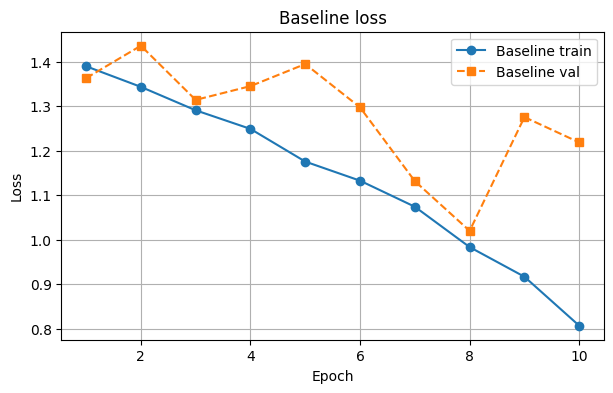


Evaluating baseline model n.1 on test set:
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5250 - loss: 1.2047
_____________________________________________________________________________

Training baseline model n.2 with random seed: 1234
Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.2088 - loss: 1.4241
Epoch 1: val_loss improved from None to 1.35746, saving model to checkpoints/baseline_best2.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.2468 - loss: 1.3939 - val_accuracy: 0.1467 - val_loss: 1.3575 - learning_rate: 0.0010
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.2613 - loss: 1.3663
Epoch 2: val_loss improved from 1.35746 to 1.30555, saving model to checkpoints/baseline_best2.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.2718 - loss: 1.3596 - val_accuracy: 0.3800 - val_loss: 1.3056 - learning_rate: 0.0010
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3549 - loss: 1.3367
Epoch 3: val_loss did not improve from 1.30555
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.3787 - loss: 1.3190 - val_accuracy: 0.1667 - val_loss: 1.4173 - learning_rate: 0.0010
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3238 - loss: 1.3013
Epoch 4: val_loss improved from 1.30555 to 1.21508, saving model to checkpoints/baseline_best2.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.3756 - loss: 1.2827 - val_accuracy: 0.4533 - val_loss: 1.2151 - learning_rate: 0.0010
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4289 - loss: 1.2195
Epoch 5: val_loss did not improve from 1.21508
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.4455 - loss: 1.2168 - val_accuracy: 0.4067 - val_loss: 1.2876 - learning_rate: 0.0010
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4990 - loss: 1.1480
Epoch 6: val_loss improved from 1.21508 to 1.10488, saving model to checkpoints/baseline_best2.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.5298 - loss: 1.1336 - val_accuracy: 0.5667 - val_loss: 1.1049 - learning_rate: 0.0010
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5322 - loss: 1.0981
Epoch 7: val_loss did not improve from 1.10488
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.5674 - loss: 1.0816 - val_accuracy: 0.5467 - val_loss: 1.1414 - learning_rate: 0.0010
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5450 - loss: 1.0101
Epoch 8: val_loss improved from 1.10488 to 1.07776, saving model to checkpoints/baseline_best2.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.5743 - loss: 1.0000 - val_accuracy: 0.5533 - val_loss: 1.0778 - learning_rate: 0.0010
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5695 - loss: 0.9416
Epoch 9: val_loss improved from 1.07776 to 1.03851, saving model to checkpoints/baseline_best2.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.6074 - loss: 0.9344 - val_accuracy: 0.5667 - val_loss: 1.0385 - learning_rate: 0.0010
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5956 - loss: 0.8607
Epoch 10: val_loss did not improve from 1.03851
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.6210 - loss: 0.8336 - val_accuracy: 0.5667 - val_loss: 1.0996 - learning_rate: 0.0010


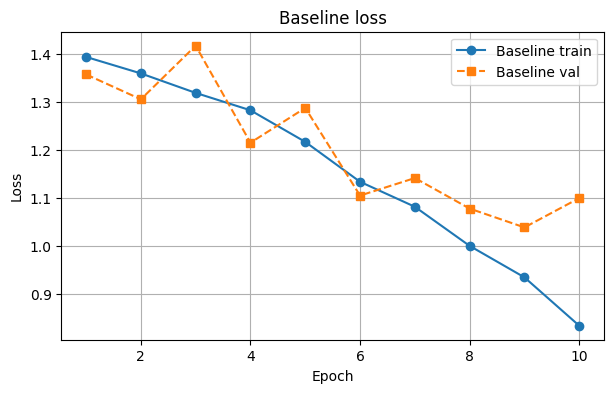


Evaluating baseline model n.2 on test set:
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5321 - loss: 1.0882
_____________________________________________________________________________
-------------------------------------------------------------
Baseline Test Accuracy: 0.5321 +/- 0.0058


In [42]:
from tensorflow.keras.models import load_model
baseline = {}

baseline_acc_list = []
for i in range(len(seeds)):
    seed = seeds[i]
    print(f"\nTraining baseline model n.{i} with random seed: {seed}")
    set_seed(seed)

    baseline_ckpt = ModelCheckpoint(
        filepath='checkpoints/baseline_best'+str(i)+'.h5',  # or 'checkpoints/baseline_best' for SavedModel dir
        monitor='val_loss',                       # metric to monitor
        save_best_only=True,
        save_weights_only=False,                  # False -> save full model
        mode='min',                               # 'min' for val_loss, 'max' for val_accuracy
        verbose=1
    )

    baseline_callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
        baseline_ckpt
    ]
    
    # MODEL DEFINITION
    baseline[i] = Sequential([
        # embedding layer
        embedding,
        # Bidirectional LSTM layer
        Bidirectional(LSTM(64, return_sequences=False)),
        # Fully connected (Dense) layer
        Dense((64), activation='relu'),
        Dropout(0.5),
        # Output layer
        Dense(4, activation='softmax')
    ])
    baseline[i].compile(
        loss='sparse_categorical_crossentropy',  # or 'categorical_crossentropy' if one-hot encoded
        optimizer=Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )

    #training the model
    bl_history = baseline[i].fit(
        x=X_train,
        y=y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=32,
        shuffle=True,
        class_weight=class_weight_dict,
        callbacks=baseline_callbacks,
        verbose=1
    )

    baseline[i] = load_model('checkpoints/baseline_best'+str(i)+'.h5')
    plot_train_val_loss(bl_history, label='Baseline')

    print(f"\nEvaluating baseline model n.{i} on test set:")
    baseline_loss, baseline_acc = baseline[i].evaluate(X_test, y_test, batch_size=32)
    baseline_acc_list.append(baseline_acc)
    print('_____________________________________________________________________________')

print('-------------------------------------------------------------')
st_dev = np.std(baseline_acc_list)
print(f'Baseline Test Accuracy: {np.mean(baseline_acc_list):.4f} +/- {st_dev:.4f}')

## Stacked Model Training


Training baseline model n.0 with random seed: 42
Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.3549 - loss: 1.3872
Epoch 1: val_loss improved from None to 1.41764, saving model to checkpoints/stacked_best0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 122ms/step - accuracy: 0.3609 - loss: 1.3775 - val_accuracy: 0.1667 - val_loss: 1.4176 - learning_rate: 0.0010
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.2707 - loss: 1.3308
Epoch 2: val_loss did not improve from 1.41764
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.2635 - loss: 1.3487 - val_accuracy: 0.1667 - val_loss: 1.4380 - learning_rate: 0.0010
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.2360 - loss: 1.3344
Epoch 3: val_loss improved from 1.41764 to 1.35237, saving model to checkpoints/stacked_best0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.2684 - loss: 1.3351 - val_accuracy: 0.1867 - val_loss: 1.3524 - learning_rate: 0.0010
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.2782 - loss: 1.2892
Epoch 4: val_loss improved from 1.35237 to 1.32844, saving model to checkpoints/stacked_best0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.2812 - loss: 1.2988 - val_accuracy: 0.2867 - val_loss: 1.3284 - learning_rate: 0.0010
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.3916 - loss: 1.2570
Epoch 5: val_loss improved from 1.32844 to 1.07171, saving model to checkpoints/stacked_best0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.4017 - loss: 1.2738 - val_accuracy: 0.6333 - val_loss: 1.0717 - learning_rate: 0.0010
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.4709 - loss: 1.2129
Epoch 6: val_loss did not improve from 1.07171
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.4626 - loss: 1.2062 - val_accuracy: 0.6000 - val_loss: 1.1196 - learning_rate: 0.0010
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5381 - loss: 1.1766
Epoch 7: val_loss did not improve from 1.07171
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.5242 - loss: 1.1812 - val_accuracy: 0.6133 - val_loss: 1.1228 - learning_rate: 0.0010
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.5389 - loss: 1.1120
Epoch 8: val_loss did not improve from 1.07171
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.5325 - loss: 1.1247 - val_accuracy: 0.5667 - val_loss: 1.1372 - learning_rate: 0.0010
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━

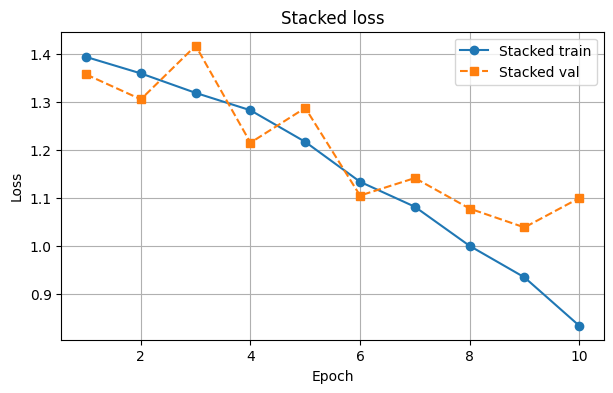


Evaluating stacked model n.0 on test set:
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5643 - loss: 1.1048
_____________________________________________________________________________

Training baseline model n.1 with random seed: 1312
Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.1702 - loss: 1.4371
Epoch 1: val_loss improved from None to 1.32576, saving model to checkpoints/stacked_best1.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - accuracy: 0.2638 - loss: 1.3781 - val_accuracy: 0.2067 - val_loss: 1.3258 - learning_rate: 0.0010
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.1884 - loss: 1.4028
Epoch 2: val_loss improved from 1.32576 to 1.31000, saving model to checkpoints/stacked_best1.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 0.2548 - loss: 1.3506 - val_accuracy: 0.3267 - val_loss: 1.3100 - learning_rate: 0.0010
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.2484 - loss: 1.3642
Epoch 3: val_loss improved from 1.31000 to 1.25797, saving model to checkpoints/stacked_best1.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.2993 - loss: 1.3139 - val_accuracy: 0.4267 - val_loss: 1.2580 - learning_rate: 0.0010
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.2959 - loss: 1.3364
Epoch 4: val_loss did not improve from 1.25797
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - accuracy: 0.3087 - loss: 1.2859 - val_accuracy: 0.3800 - val_loss: 1.2951 - learning_rate: 0.0010
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.3668 - loss: 1.2957
Epoch 5: val_loss improved from 1.25797 to 1.19326, saving model to checkpoints/stacked_best1.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - accuracy: 0.4184 - loss: 1.2297 - val_accuracy: 0.5200 - val_loss: 1.1933 - learning_rate: 0.0010
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.4348 - loss: 1.2355
Epoch 6: val_loss improved from 1.19326 to 1.12638, saving model to checkpoints/stacked_best1.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.4650 - loss: 1.1719 - val_accuracy: 0.6000 - val_loss: 1.1264 - learning_rate: 0.0010
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4889 - loss: 1.1963
Epoch 7: val_loss improved from 1.12638 to 1.09237, saving model to checkpoints/stacked_best1.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - accuracy: 0.5092 - loss: 1.1326 - val_accuracy: 0.5667 - val_loss: 1.0924 - learning_rate: 0.0010
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.4956 - loss: 1.1370
Epoch 8: val_loss did not improve from 1.09237
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.5437 - loss: 1.0543 - val_accuracy: 0.5867 - val_loss: 1.1199 - learning_rate: 0.0010
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.5351 - loss: 1.0421
Epoch 9: val_loss improved from 1.09237 to 1.07041, saving model to checkpoints/stacked_best1.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.5799 - loss: 0.9646 - val_accuracy: 0.5733 - val_loss: 1.0704 - learning_rate: 0.0010
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5314 - loss: 0.9644
Epoch 10: val_loss did not improve from 1.07041
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - accuracy: 0.5900 - loss: 0.8888 - val_accuracy: 0.5600 - val_loss: 1.0830 - learning_rate: 0.0010


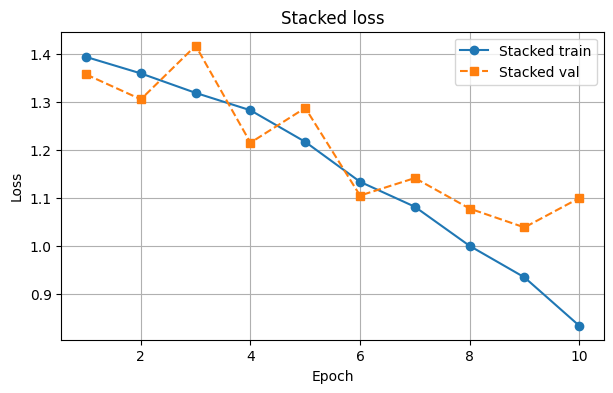


Evaluating stacked model n.1 on test set:
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5107 - loss: 1.1528
_____________________________________________________________________________

Training baseline model n.2 with random seed: 1234
Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.2241 - loss: 1.4064
Epoch 1: val_loss improved from None to 1.34457, saving model to checkpoints/stacked_best2.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - accuracy: 0.2590 - loss: 1.3865 - val_accuracy: 0.2467 - val_loss: 1.3446 - learning_rate: 0.0010
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.2853 - loss: 1.3617
Epoch 2: val_loss improved from 1.34457 to 1.30187, saving model to checkpoints/stacked_best2.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.2652 - loss: 1.3516 - val_accuracy: 0.3467 - val_loss: 1.3019 - learning_rate: 0.0010
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.3379 - loss: 1.3473
Epoch 3: val_loss improved from 1.30187 to 1.26297, saving model to checkpoints/stacked_best2.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.3028 - loss: 1.3250 - val_accuracy: 0.5000 - val_loss: 1.2630 - learning_rate: 0.0010
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.3764 - loss: 1.2932
Epoch 4: val_loss did not improve from 1.26297
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.3498 - loss: 1.2887 - val_accuracy: 0.2867 - val_loss: 1.3409 - learning_rate: 0.0010
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.3818 - loss: 1.2415
Epoch 5: val_loss improved from 1.26297 to 1.04643, saving model to checkpoints/stacked_best2.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - accuracy: 0.3884 - loss: 1.2247 - val_accuracy: 0.6267 - val_loss: 1.0464 - learning_rate: 0.0010
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.4814 - loss: 1.1671
Epoch 6: val_loss did not improve from 1.04643
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.4340 - loss: 1.1850 - val_accuracy: 0.4333 - val_loss: 1.2433 - learning_rate: 0.0010
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4614 - loss: 1.1409
Epoch 7: val_loss did not improve from 1.04643
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.4835 - loss: 1.1288 - val_accuracy: 0.5533 - val_loss: 1.1564 - learning_rate: 0.0010
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.4874 - loss: 1.0951
Epoch 8: val_loss improved from 1.04643 to 1.03795, saving model to checkpoints/stacked_best2.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.5026 - loss: 1.0826 - val_accuracy: 0.6133 - val_loss: 1.0380 - learning_rate: 0.0010
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.5370 - loss: 0.9809
Epoch 9: val_loss improved from 1.03795 to 0.97752, saving model to checkpoints/stacked_best2.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.5399 - loss: 0.9942 - val_accuracy: 0.6600 - val_loss: 0.9775 - learning_rate: 0.0010
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5536 - loss: 0.9047
Epoch 10: val_loss improved from 0.97752 to 0.92236, saving model to checkpoints/stacked_best2.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.5409 - loss: 0.9159 - val_accuracy: 0.6600 - val_loss: 0.9224 - learning_rate: 0.0010


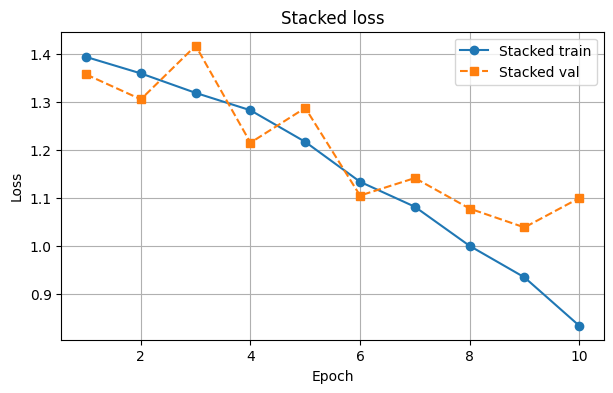


Evaluating stacked model n.2 on test set:
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5643 - loss: 1.0203
_____________________________________________________________________________
-------------------------------------------------------------
Stacked Test Accuracy: 0.5464 +/- 0.0253


In [43]:
stacked_model = {}

stacked_model_acc_list = []
for i in range(len(seeds)):
    seed = seeds[i]
    print(f"\nTraining baseline model n.{i} with random seed: {seed}")
    set_seed(seed)

    stacked_ckpt = ModelCheckpoint(
        filepath='checkpoints/stacked_best'+str(i)+'.h5',  # or 'checkpoints/stacked_best' for SavedModel dir
        monitor='val_loss',                       # metric to monitor
        save_best_only=True,
        save_weights_only=False,                  # False -> save full model
        mode='min',                               # 'min' for val_loss, 'max' for val_accuracy
        verbose=1
    )

    stacked_callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
        stacked_ckpt
    ]

    # MODEL DEFINITION
    stacked_model[i] = Sequential([
        # embedding layer
        embedding,
        # 1st Bidirectional LSTM layer
        Bidirectional(LSTM(32, return_sequences=True)),
        # 2nd Bidirectional LSTM layer
        Bidirectional(LSTM(32)),
        # Fully connected (Dense) layer
        Dense(32, activation='relu'),
        Dropout(0.5),
        # Output layer
        Dense(4, activation='softmax')
    ])
    
    stacked_model[i].compile(
        loss='sparse_categorical_crossentropy',  # or 'categorical_crossentropy' if one-hot encoded
        optimizer=Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )

    #training the model
    st_history = stacked_model[i].fit(
        x=X_train,
        y=y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=32,
        shuffle=True,
        class_weight=class_weight_dict,
        callbacks=stacked_callbacks,
        verbose=1
    )

    # plot_train_val_loss(st_history, label='Stacked')
    stacked_model[i] = load_model('checkpoints/stacked_best'+str(i)+'.h5')
    plot_train_val_loss(st_history, label='Stacked')

    print(f"\nEvaluating stacked model n.{i} on test set:")
    stacked_model_loss, stacked_model_acc = stacked_model[i].evaluate(X_test, y_test, batch_size=32)
    stacked_model_acc_list.append(stacked_model_acc)
    print('_____________________________________________________________________________')

print('-------------------------------------------------------------')
st_dev = np.std(stacked_model_acc_list)
print(f'Stacked Test Accuracy: {np.mean(stacked_model_acc_list):.4f} +/- {st_dev:.4f}')

Load and evaluate the models

In [44]:
from tensorflow.keras.models import load_model
stacked_best = load_model('checkpoints/stacked_best.h5')

In [45]:
stacked_loss, stacked_acc = stacked_best.evaluate(X_test, y_test, batch_size=32)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5571 - loss: 1.0456


# [Task 6 - 1.0 points] Transformers

In this section, you will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate).




### Relevant Material
- Tutorial 3

### Instructions
- **Load the Tokenizer and Model**

- **Preprocess the Dataset**:
   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.

- **Train the Model**:
   Use the `Trainer` to train the model on your training data.

- **Evaluate the Model on the Test Set** using the same metrics used for LSTM-based models.

In [46]:
import torch
import pandas as pd
torch.cuda.is_available()

False

In [47]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 1. Load Tokenizer from the 'base' model (where the vocab files actually exist)
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base")

# 2. Load the Model from the 'hate' checkpoint
model_card = "cardiffnlp/twitter-roberta-base-hate"
model = AutoModelForSequenceClassification.from_pretrained(model_card)

print("Success: Tokenizer and Model loaded separately.")

c:\Users\dales\miniconda3\envs\nlp_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Success: Tokenizer and Model loaded separately.


In [48]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import XLMRobertaTokenizer

import numpy as np
from scipy.special import softmax
import csv
import urllib.request

# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='hate'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base")

# For windows systems
new_save_directory = "./my_local_hate_model" 
# model.save_pretrained(new_save_directory)
# tokenizer.save_pretrained(new_save_directory)

# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(new_save_directory)

text = "Good night 😊"
text = preprocess(text)
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

# # TF
# model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)
# model.save_pretrained(MODEL)

# text = "Good night 😊"
# encoded_input = tokenizer(text, return_tensors='tf')
# output = model(encoded_input)
# scores = output[0][0].numpy()
# scores = softmax(scores)

ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = labels[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")


1) not-hate 0.9168
2) hate 0.0832


In [99]:
train_df = pd.read_csv('cleaned_train.csv')
val_df = pd.read_csv('cleaned_validation.csv')
test_df = pd.read_csv('cleaned_test.csv')

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Training samples: 2873
Validation samples: 150
Test samples: 280


In [50]:
# from transformers import AutoTokenizer

# task='hate'
# model_card = f"cardiffnlp/twitter-roberta-base-{task}"

# tokenizer = AutoTokenizer.from_pretrained(
#     model_card, 
#     force_download=True, 
#     use_fast=False
# )

In [100]:
from datasets import Dataset

train_data = Dataset.from_pandas(train_df)
val_data = Dataset.from_pandas(val_df)
test_data = Dataset.from_pandas(test_df)


In [52]:
def preprocess_text(texts):
    return tokenizer(texts['tweet'], truncation=True)

train_data = train_data.map(preprocess_text, batched=True)
val_data = val_data.map(preprocess_text, batched = True)
test_data = test_data.map(preprocess_text, batched=True)

Map: 100%|██████████| 280/280 [00:00<00:00, 11590.02 examples/s]


In [53]:
print(train_data)
print(val_data)
print(test_data)
print(train_data['input_ids'][12][:200])
print(train_data['attention_mask'][12][:200])

original_text = train_data['tweet'][12]
decoded_text = tokenizer.decode(train_data['input_ids'][12])

print(original_text[:200])
print()
print()
print(decoded_text[:200])

"""
Do later: use the data before the preprocessing that we did.

"""

Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2873
})
Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'label', 'input_ids', 'attention_mask'],
    num_rows: 150
})
Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'label', 'input_ids', 'attention_mask'],
    num_rows: 280
})
[0, 1990, 2512, 9, 768, 479, 905, 579, 386, 19, 5, 98, 486, 3959, 582, 4044, 19, 10, 3104, 7, 41, 15, 29, 1842, 479, 42, 1937, 28, 41, 1246, 9, 596, 28228, 28, 240, 479, 939, 385, 101, 7, 1606, 14, 66, 9, 27983, 21554, 4289, 129, 389, 28, 7923, 98, 24, 269, 28, 41, 696, 204, 195, 2]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
for yourself of course . let s start with the so call gender pay gap with a link to an ons page . this alone be an example of why feminism be need . i d like to add that out of 164 emoji

'\nDo later: use the data before the preprocessing that we did.\n\n'

In [54]:
from transformers import AutoModelForSequenceClassification
import numpy as np
import csv
import urllib.request

In [55]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_card,
    num_labels=4,
    ignore_mismatched_sizes=True,
    use_safetensors=True   # <-- force safetensors if available
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
import evaluate

acc_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')

In [57]:
def compute_metrics(output_info):
    predictions, labels = output_info
    predictions = np.argmax(predictions, axis=-1)
    
    f1 = f1_metric.compute(predictions=predictions,
                           references=labels,
                           average='macro')
    acc = acc_metric.compute(predictions=predictions, 
                             references=labels)
    return {**f1, **acc}

In [58]:
import accelerate

accelerate.__version__

'1.12.0'

In [59]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="test_dir",             # where to save model
    learning_rate=2e-5,                   
    per_device_train_batch_size=8,     # defines distributed training
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",             # when to report evaluation metrics/losses
    save_strategy="epoch",             # when to save checkpoint
    load_best_model_at_end=True,
    report_to='none'                   # disabling wandb (default)
)

In [60]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [61]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [62]:
trainer.train()

c:\Users\dales\miniconda3\envs\nlp_env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

# [Task 7 - 0.5 points] Error Analysis

After evaluating the model, perform a brief error analysis:

### Instructions

 - Review the results and identify common errors.

 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)
 - Suggest possible solutions to address the identified errors.

## First step: confusion matrices

We start with plotting the confusion matrices of both the stacked model and the transformer results to evaluate false positive and false negatives.

Generating Confusion Matrix for LSTM Model...
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 423ms/step


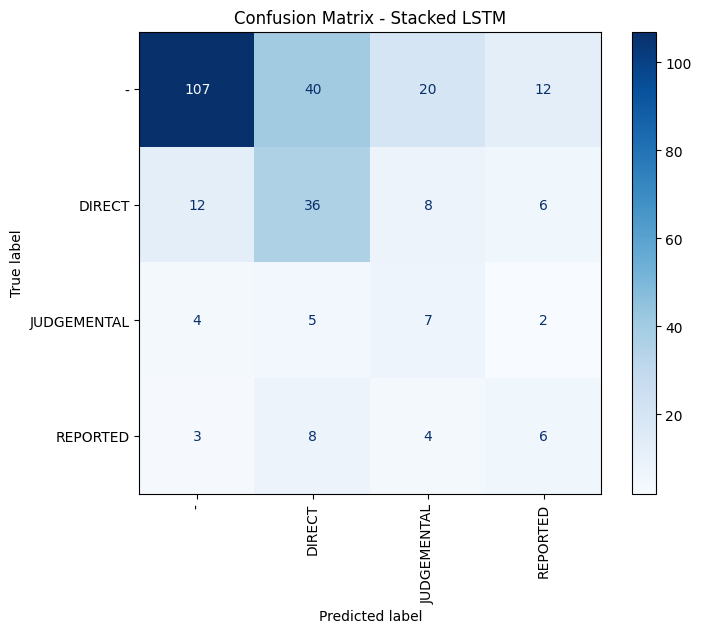


Generating Confusion Matrix for Transformer Model...


c:\Users\dales\miniconda3\envs\nlp_env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


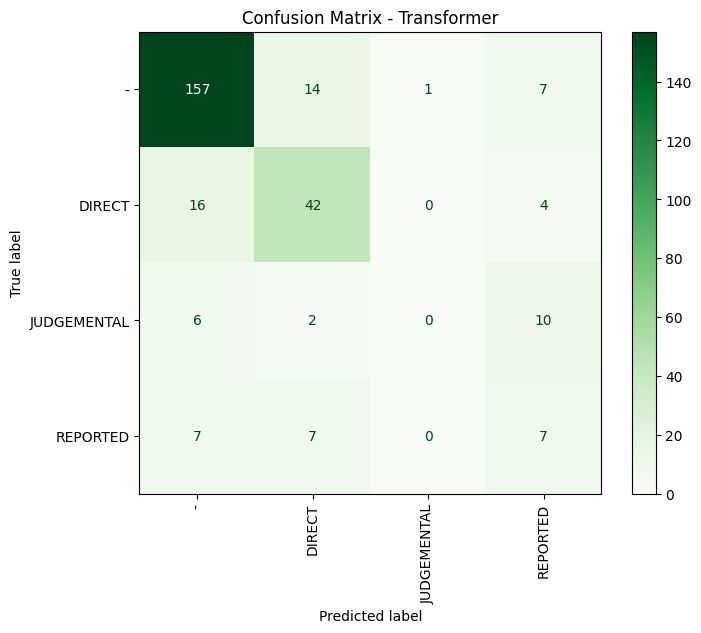

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Define class names based on your mapping
# 0: '-', 1: 'DIRECT', 2: 'JUDGEMENTAL', 3: 'REPORTED'
class_names = ['-', 'DIRECT', 'JUDGEMENTAL', 'REPORTED']


# Confusion Matrix for LSTM Model
if 'stacked_best' in globals():
    print("Generating Confusion Matrix for LSTM Model...")
    
    # Get predictions on the test set
    y_pred_probs = stacked_best.predict(X_test)
    y_pred_lstm = np.argmax(y_pred_probs, axis=1)

    # Compute confusion matrix
    cm_lstm = confusion_matrix(y_test, y_pred_lstm)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=class_names)
    disp_lstm.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    ax.set_title("Confusion Matrix - Stacked LSTM")
    plt.show()
else:
    print("LSTM model 'stacked_best' not found in memory.")

# Confusion Matrix for Transformer Model
if 'trainer' in globals():
    print("\nGenerating Confusion Matrix for Transformer Model...")
    
    # Get predictions from the trainer on the test dataset
    output = trainer.predict(test_data)
    y_pred_transformer = np.argmax(output.predictions, axis=1)
    y_true_transformer = output.label_ids

    # Compute confusion matrix
    cm_transformer = confusion_matrix(y_true_transformer, y_pred_transformer)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    disp_transformer = ConfusionMatrixDisplay(confusion_matrix=cm_transformer, display_labels=class_names)
    disp_transformer.plot(cmap=plt.cm.Greens, ax=ax, xticks_rotation='vertical')
    ax.set_title("Confusion Matrix - Transformer")
    plt.show()
else:
    print("Transformer 'trainer' not found in memory.")


We can immediately notice how the stacked model, other than having worse accuracy, also shows a higher count of false positive (detected sexism when the label says there is none) compared to the more balanced output of the transformer.

# Step two: confidence vs accuracy

Generating Confidence vs Accuracy for LSTM Model...
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


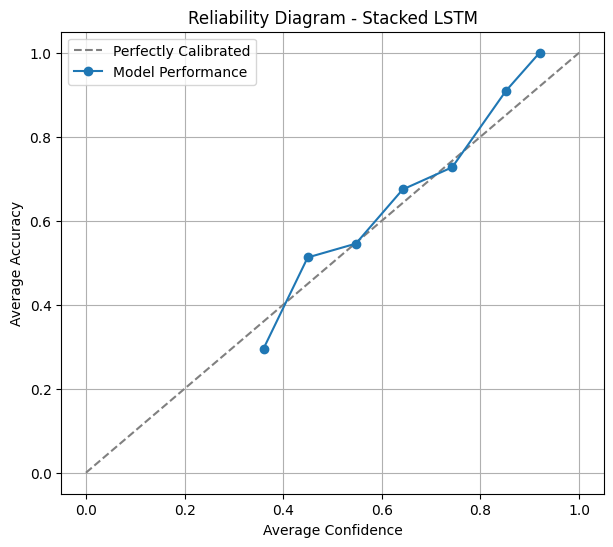


Generating Confidence vs Accuracy for Transformer Model...


c:\Users\dales\miniconda3\envs\nlp_env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


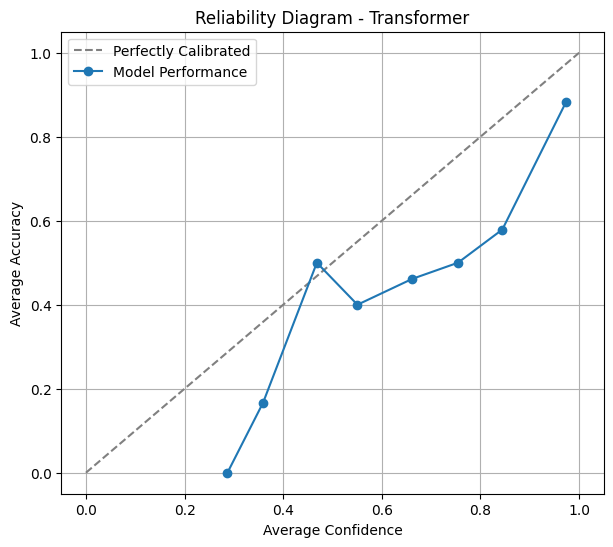

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax

def plot_confidence_vs_accuracy(y_true, y_probs, title="Confidence vs Accuracy", n_bins=10):
    """
    Plots a reliability diagram (Confidence vs Accuracy) for multi-class classification.
    """
    # Get predictions (argmax) and confidences (max probability)
    y_pred = np.argmax(y_probs, axis=1)
    confidences = np.max(y_probs, axis=1)
    
    # Check correctness of predictions (1 if correct, 0 if wrong)
    accuracies = (y_pred == y_true).astype(int)
    
    # Define bins
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_accs = []
    bin_confs = []
    
    for i in range(n_bins):
        lower = bin_edges[i]
        upper = bin_edges[i+1]
        
        # Handle the last bin to include 1.0 exactly
        if i == n_bins - 1:
            mask = (confidences >= lower) & (confidences <= upper)
        else:
            mask = (confidences >= lower) & (confidences < upper)
            
        # Only calculate if there are samples in this bin
        if np.sum(mask) > 0:
            bin_accs.append(np.mean(accuracies[mask]))
            bin_confs.append(np.mean(confidences[mask]))
            
    # Plotting
    plt.figure(figsize=(7, 6))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    plt.plot(bin_confs, bin_accs, marker='o', label='Model Performance')
    plt.xlabel('Average Confidence')
    plt.ylabel('Average Accuracy')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# ---------------------------------------------------------
# 1. Plot for LSTM Model
# ---------------------------------------------------------
if 'stacked_best' in globals():
    print("Generating Confidence vs Accuracy for LSTM Model...")
    # Get probabilities from the model
    y_probs_lstm = stacked_best.predict(X_test)
    plot_confidence_vs_accuracy(y_test, y_probs_lstm, title="Reliability Diagram - Stacked LSTM")
else:
    print("LSTM model 'stacked_best' not found in memory.")

# ---------------------------------------------------------
# 2. Plot for Transformer Model
# ---------------------------------------------------------
if 'trainer' in globals():
    print("\nGenerating Confidence vs Accuracy for Transformer Model...")
    # Get logits from trainer and convert to probabilities using softmax
    output = trainer.predict(test_data)
    y_probs_transformer = softmax(output.predictions, axis=1)
    y_true_transformer = output.label_ids
    
    plot_confidence_vs_accuracy(y_true_transformer, y_probs_transformer, title="Reliability Diagram - Transformer")
else:
    print("Transformer 'trainer' not found in memory.")



## Step three: comparison of the misclassified samples with secondary predictions
The hypothesis that our models might be misclassifying samples that have thin margin of confidence arose, so we analyzed the possibility that our models might be correctly predicting the second most voted class instead. 

In [ ]:
import pandas as pd
import numpy as np

def get_misclassified_samples(model, X, y_true, df, model_type='lstm', trainer=None):
    
    # Define inverse mapping for readability
    inv_mapping = {0: '-', 1: 'DIRECT', 2: 'JUDGEMENTAL', 3: 'REPORTED'}

    if model_type == 'lstm':
        # Get probabilities and convert to class indices
        y_pred_probs = model.predict(X, verbose=0)
        y_pred = np.argmax(y_pred_probs, axis=1)
        
    elif model_type == 'transformer':
        if trainer is None:
            raise ValueError("Please provide the 'trainer' argument for Transformer models.")
        # Trainer.predict returns predictions (logits) and label_ids
        output = trainer.predict(X)
        y_pred = np.argmax(output.predictions, axis=1)
        y_true = output.label_ids
        
    else:
        raise ValueError("Invalid model_type. Choose 'lstm' or 'transformer'.")

    # Find indices where predictions do not match true labels
    error_indices = np.where(y_pred != y_true)[0]
    
    # Filter the original DataFrame using iloc to ensure alignment
    error_df = df.iloc[error_indices].copy()
    
    # Add prediction info
    error_df['true_label_id'] = y_true[error_indices]
    error_df['pred_label_id'] = y_pred[error_indices]
    error_df['true_label_str'] = error_df['true_label_id'].map(inv_mapping)
    error_df['pred_label_str'] = error_df['pred_label_id'].map(inv_mapping)
    
    return error_df

# Assuming 'baseline_model' is your trained Keras model
lstm_errors = get_misclassified_samples(
    model=stacked_best, 
    X=X_test, 
    y_true=y_test, 
    df=test_df, 
    model_type='lstm'
).copy()

# Display first few errors
# lstm_errors.to_csv('lstm_misclassified_samples.csv', index=False)



In [147]:
# number of times the model predicted 'secondary' correctly
count = (lstm_errors['secondary'] == lstm_errors['pred_label_str']).sum()
count_all = len(lstm_errors)

print(f"The number of samples that have been correctly predicted as belonging to the secondary class is {count} out of {count_all}" )

The number of samples that have been correctly predicted as belonging to the secondary class is 37 out of 124


In [ ]:
lstm_true_error = lstm_errors[lstm_errors['secondary'] != lstm_errors['pred_label_str']].copy()


In [142]:
def get_tweet_text(id_num):
    # Ensure we look for the string version if your IDs are strings
    match = df_test_en[df_test_en['id_EXIST'] == str(id_num)]
    if not match.empty:
        return match['tweet'].values[0]
    return None # Handle cases where ID might be missing

# Use a lambda to apply the function row by row
lstm_true_error['original_tweet'] = lstm_true_error['id_EXIST'].apply(lambda x: get_tweet_text(x))

In [128]:
def og_tweet(id_num, df):
    tweet = df[df['id_EXIST'] == str(id_num)]['tweet'].values[0]
    return tweet

lstm_true_error['original_tweet'] = lstm_true_error['id_EXIST'].apply(lambda x: og_tweet(x, df_test_en))

C:\Users\dales\AppData\Local\Temp\ipykernel_15912\3229363887.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstm_true_error['original_tweet'] = lstm_true_error['id_EXIST'].apply(lambda x: og_tweet(x, df_test_en))


In [145]:
lstm_true_error.head()

,id_EXIST,lang,tweet,label,secondary,true_label_id,pred_label_id,true_label_str,pred_label_str,original_tweet
6,400186,en,maybe something involve her get gangbanged ?,1,REPORTED,1,0,DIRECT,-,@Fox_x_Gods Maybe something involving her gett...
13,400194,en,the violent antifeminism of a far right moveme...,3,DIRECT,3,0,REPORTED,-,"""The violent antifeminism of a far-right movem..."
14,400195,en,ah ! look ! gender role be back too ! the don ...,1,JUDGEMENTAL,1,0,DIRECT,-,@MrsGreyBull @Miriam2626 Ah! Look! Gender role...
15,400196,en,yes hayley hafu representation give our japane...,0,JUDGEMENTAL,0,1,-,DIRECT,@earth2kayla yes hayley hafu representation gi...
18,400199,en,how do we reach a point where blonks be have t...,0,DIRECT,0,2,-,JUDGEMENTAL,@EyemotionFandom How did we reach a point wher...


In [146]:
lstm_true_error.to_csv('lstm_true_misclassified_samples.csv', index=False)

# [Task 8 - 0.5 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is **not a copy-paste** of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.


# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

## Bonus Points
Bonus points are arbitrarily assigned based on significant contributions such as:
- Outstanding error analysis
- Masterclass code organization
- Suitable extensions

**Note**: bonus points are only assigned if all task points are attributed (i.e., 6/6).

**Possible Suggestions for Bonus Points:**
- **Try other preprocessing strategies**: e.g., but not limited to, explore techniques tailored specifically for tweets or  methods that are common in social media text.
- **Experiment with other custom architectures or models from HuggingFace**
- **Explore Spanish tweets**: e.g., but not limited to, leverage multilingual models to process Spanish tweets and assess their performance compared to monolingual models.

# FAQ

Please check this frequently asked questions before contacting us

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.


### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Robust Evaluation

Each model is trained with at least 3 random seeds.

Task 5 requires you to compute the average performance over the 3 seeds and its corresponding standard deviation.

### Expected Results

Task 2 leaderboard reports around 40-50 F1-score.
However, note that they perform a hierarchical classification.

That said, results around 30-40 F1-score are **expected** given the task's complexity.

### Model Selection for Analysis

To carry out the error analysis you are **free** to either

* Pick examples or perform comparisons with an individual seed run model (e.g., Baseline seed 1337)
* Perform ensembling via, for instance, majority voting to obtain a single model.

### Error Analysis

Some topics for discussion include:
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.


# The End

Feel free to reach out for questions/doubts!